# What you can do

- **in silico TF perturbation** to simulate cell identity shifts. CellOracle uses the GRN model to simulate cell identity shifts in response to TF perturbations. For this analysis, you will need the GRN models from the previous notebook.

- **Compare simulation vectors with developmental vectors.** In order to properly interpret the simulation results, it is also important to consider the natural direction of development. First, we will calculate a pseudotime gradient vector field to recapitulate the developmental flow. Then, we will compare the CellOracle TF perturbation vector field with the developmental vector field by calculating the inner product scores. Let’s call the inner product value as perturbation score (PS). Please see the step 5.6 for detail.

# Custom data class / object

In this notebook, CellOracle uses four custom classes, Oracle, Links, Gradient_calculator, and Oracle_development_module.

- `Oracle` is the main class in the CellOracle package. It is responsible for most of the calculations during GRN model construction and TF perturbation simulations.

- `Links` is a class to store GRN data.

- The `Gradient_calculator` calculates the developmental vector field from the pseudotime results.

- The `Oracle_development_module` integrates the `Oracle` object data and the `Gradient_calculator` object data to analyze how TF perturbation affects on the developmental process. It also has many visualization functions.

# 0. Import libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

'0.20.0'

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

In [4]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data

Load the oracle object.

In [5]:
cell_name = "pDC"
cell_group = "level_3"
oracle = co.load_hdf5(f"data/{cell_name}.celloracle.oracle")
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.20.0
    n_cells: 723
    n_genes: 1999
    cluster_name: level_3
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 27314 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 90 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1589 genes
    k_for_knn_imputation: 18
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In the previous notebook, we calculated the GRNs. Now, we will use these GRNs for the perturbation simulations. First, we will import the GRNs from the `Links` object.

In [6]:
links = co.load_hdf5(f"data/{cell_name}.links.celloracle.links")

## color

In [7]:
level_3_color_maps = {"pDC-C4" : "#d62728", "pDC-C7" : "#e377c2",  "pDC-C8" : "#b5bd61"}
level_3 = []
level_3_colors = []
for t in level_3_color_maps:
    if t in oracle.adata.obs[cell_group].unique():
        level_3.append(t)
        level_3_colors.append(level_3_color_maps[t])
oracle.adata.uns[f'{cell_group}_colors'] = level_3_colors
oracle.adata.obs[cell_group] = oracle.adata.obs[cell_group].astype('object')
oracle.adata.obs[cell_group] = oracle.adata.obs[cell_group].astype('category')
oracle.adata.obs[cell_group].cat.reorder_categories(level_3, inplace=True)

/tmp/ipykernel_2286/779533960.py:11: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  oracle.adata.obs[cell_group].cat.reorder_categories(level_3, inplace=True)


## Pseudotime

In [8]:
df_time = pd.read_csv(f"/work/home/project/scESCA/200227_6samples/output/04.rm_cells/monocle3_{cell_name}.pseudotime.csv")
df_time = df_time.set_index('cell')
oracle.adata.obs = oracle.adata.obs.merge(df_time, left_index=True, right_index=True)
oracle.adata.obs.head()

orig.ident   nCount_RNA  nFeature_RNA Patient    Source  \
CCACCTATCCCAAGTA-1   S0619.P1  8507.364632          2603   S0619  S0619.P1   
CCATTCGTCGCTAGCG-1   S0619.P1  7225.926360          2435   S0619  S0619.P1   
CCGTTCATCTAACTTC-1   S0619.P1  7325.181453          2574   S0619  S0619.P1   
CCTAAAGGTGCGCTTG-1   S0619.P1  5603.262402          1968   S0619  S0619.P1   
CTAGTGATCGGTGTCG-1   S0619.P1  6613.651410          2298   S0619  S0619.P1   

                   Tissue Origin  percent.mt  percent.heat  \
CCACCTATCCCAAGTA-1   PBMC  PBMC1    2.813140      0.691136   
CCATTCGTCGCTAGCG-1   PBMC  PBMC1    2.196754      0.661919   
CCGTTCATCTAACTTC-1   PBMC  PBMC1    3.324979      0.680123   
CCTAAAGGTGCGCTTG-1   PBMC  PBMC1    2.521400      0.567545   
CTAGTGATCGGTGTCG-1   PBMC  PBMC1    2.390559      0.465762   

                    percent.dissociation  ...  Origin2  Origin3  level_3  \
CCACCTATCCCAAGTA-1              2.226905  ...    PBMC1    PBMC1   pDC-C7   
CCATTCGTCGCTAGCG-1              2.191492  ...    PBMC1    PBMC1   pDC-C7   
CCGTTCATCTAACTTC-1              2.422375  ...    PBMC1    PBMC1   pDC-C7   
CCTAAAGGTGCGCTTG-1              2.325501  ...    PBMC1    PBMC1   pDC-C7   
CTAGTGATCGGTGTCG-1              2.316784  ...    PBMC1    PBMC1   pDC-C7   

                    Metastasis_n  Origin2_n Metastatic  Origin4 n_counts_all  \
CCACCTATCCCAAGTA-1          None    prePBMC          P  prePBMC  8506.378906   
CCATTCGTCGCTAGCG-1          None    prePBMC          P  prePBMC  7224.944336   
CCGTTCATCTAACTTC-1          None    prePBMC          P  prePBMC  7325.196289   
CCTAAAGGTGCGCTTG-1          None    prePBMC          P  prePBMC  5603.265625   
CTAGTGATCGGTGTCG-1          None    prePBMC          P  prePBMC  6612.663574   

                       n_counts Pseudotime  
CCACCTATCCCAAGTA-1  1655.753662   3.208343  
CCATTCGTCGCTAGCG-1  1555.356812   4.799167  
CCGTTCATCTAACTTC-1  1599.396484   2.155422  
CCTAAAGGTGCGCTTG-1  1652.175659   3.901059  
CTAGTGATCGGTGTCG-1  1611.346558   4.220210  

[5 rows x 42 columns]

# 2. Make predictive models for simulation

Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [9]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/3 [00:00<?, ?it/s]

# 3. In silico TF perturbation analysis

Next, we will simulate the TF perturbation effects on cell identity to investigate its potential functions and regulatory mechanisms. Please see the CellOracle paper for more details on scientific rationale.

In this notebook, we will simulate the knockout of the Gata1 gene in the hematopoiesis trajectory.

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation.

Here, we will use CellOracle to analyze Gata1 and attempt to recapitulate the previous findings from above.

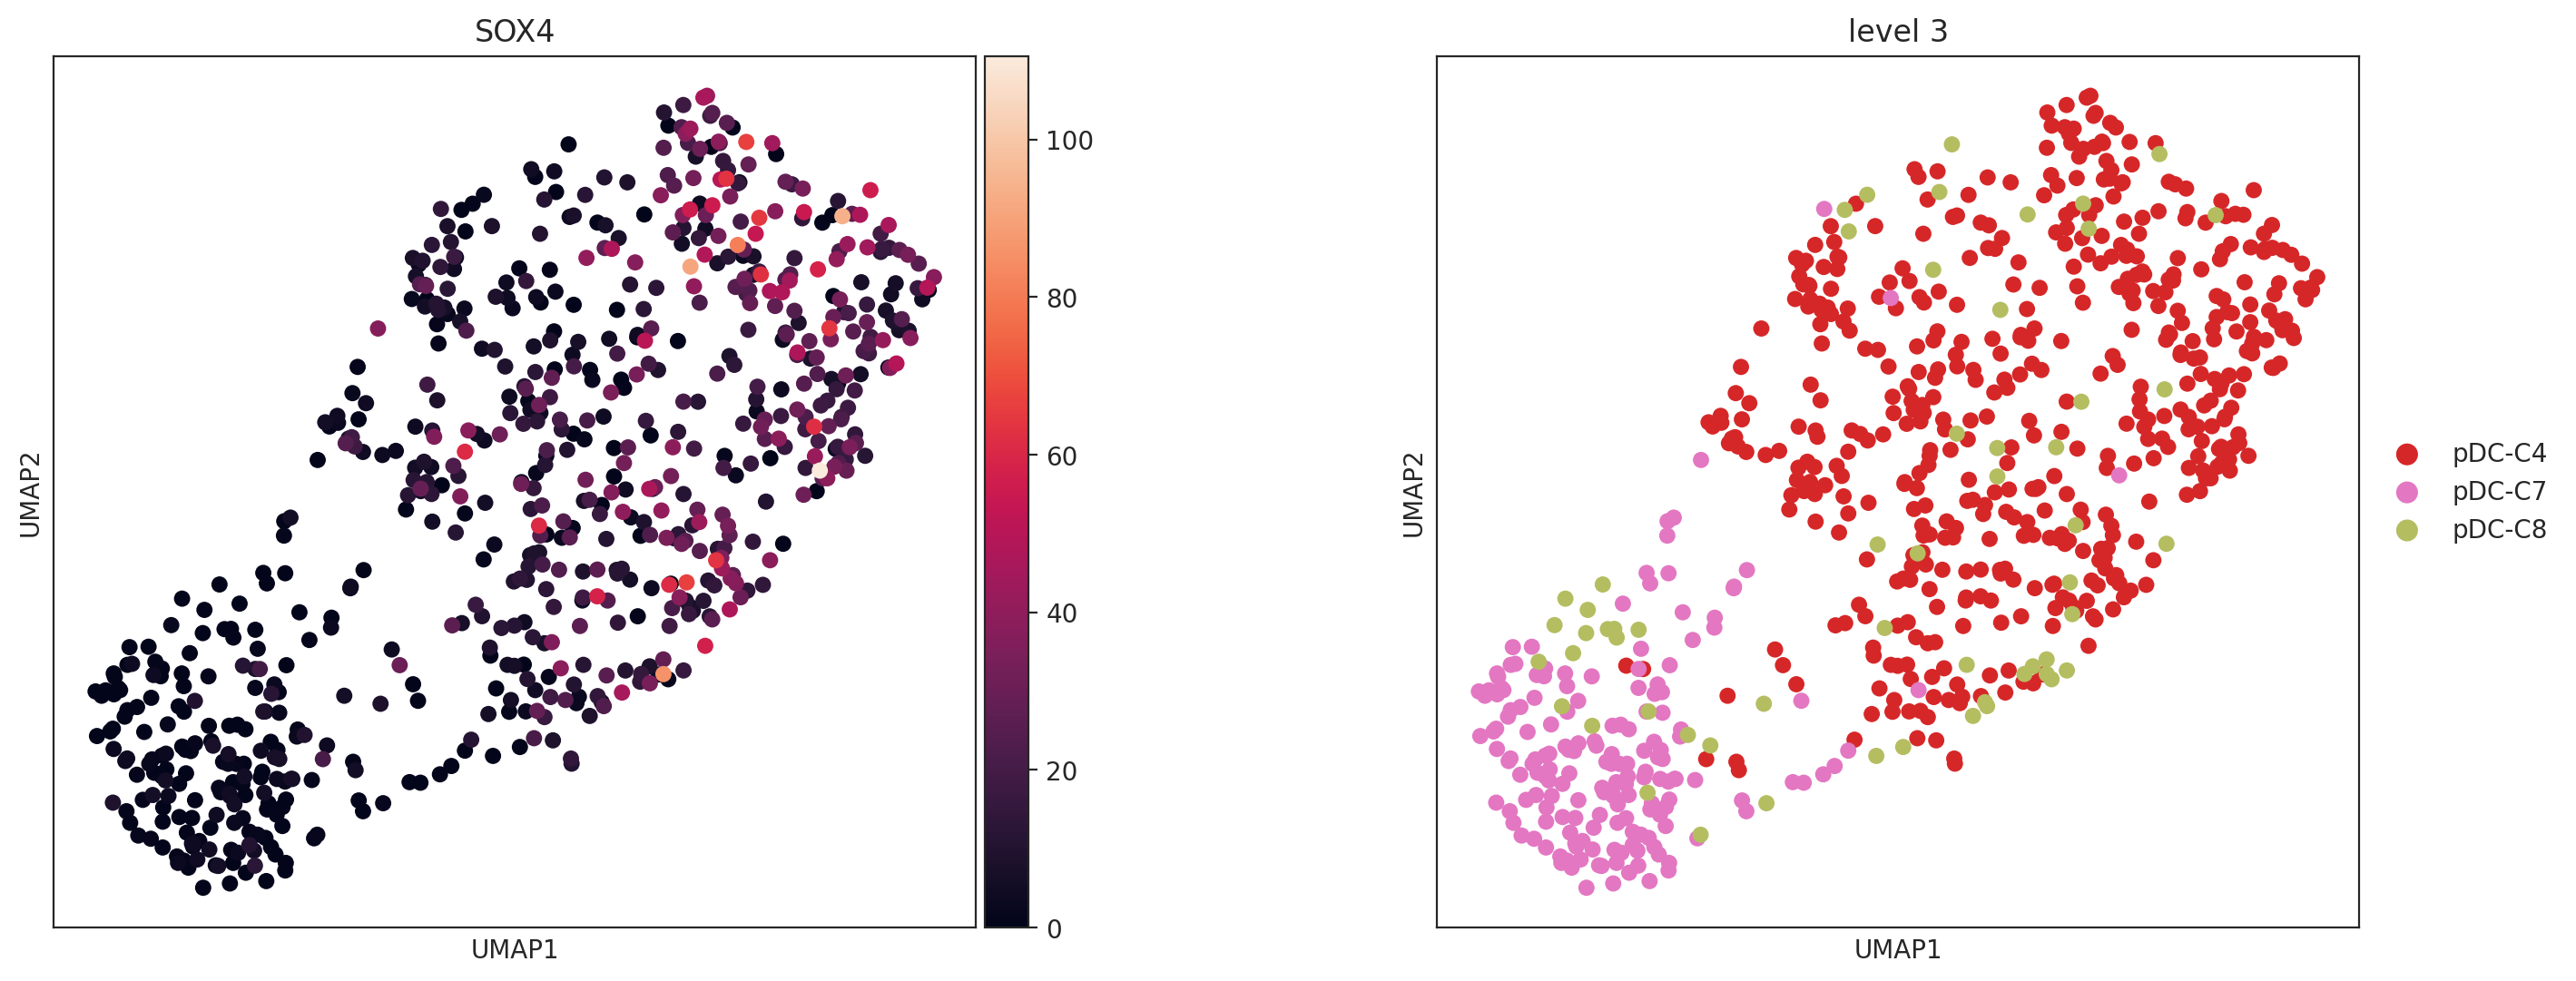

In [10]:
# Check gene expression
goi = "SOX4"
sc.pl.scatter(oracle.adata, color=[goi, oracle.cluster_column_name],
             basis="umap", layers="imputed_count")

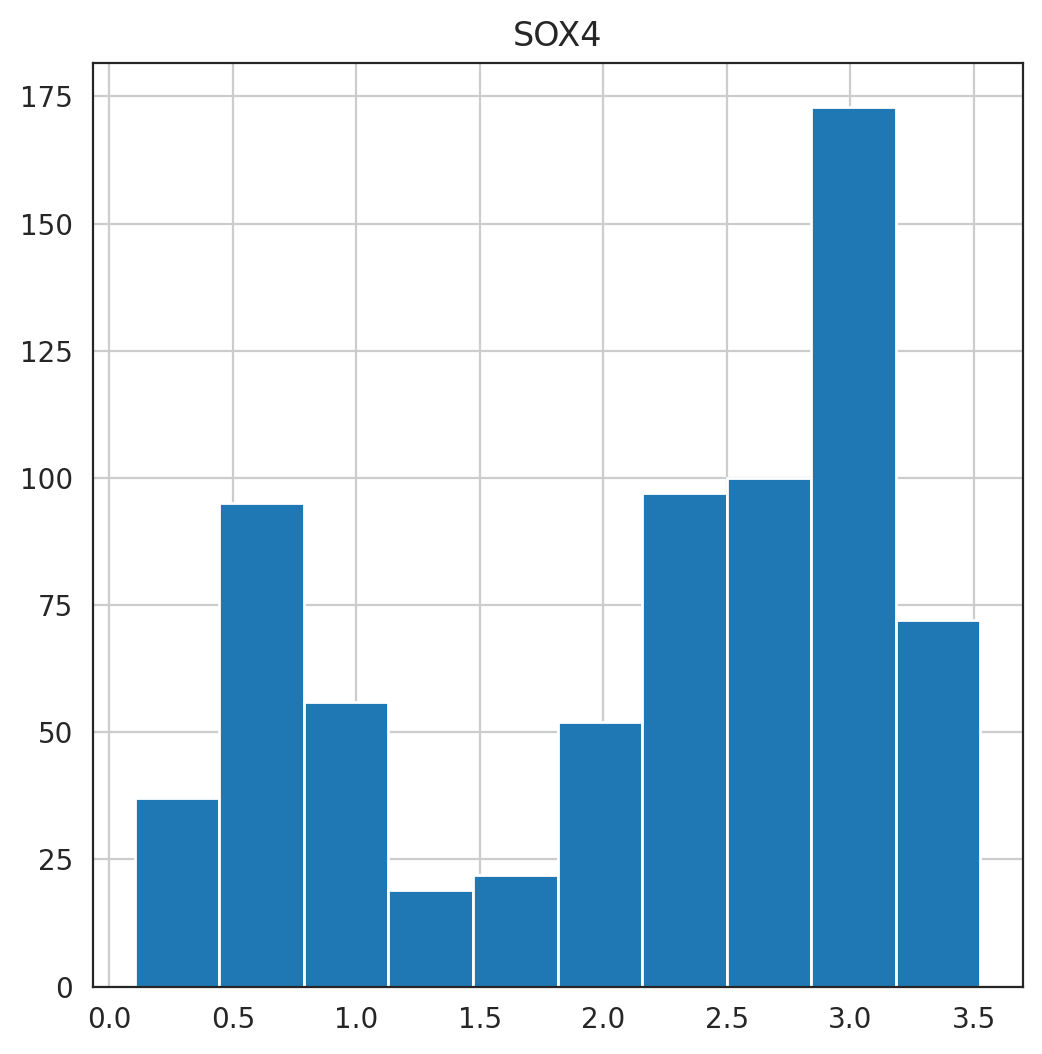

In [11]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

You can use any gene expression value in the in silico perturbations, but please avoid extremely high values that are far from the natural gene expression range. The upper limit allowed is twice the maximum gene expression.

To simulate SOX4 KO, we will set Gata1 expression to 0.

In [12]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

After simulation, celloracle automatically evaluates whether the range of simulated values is appropriate and returns a warning if there is an atypical distribution. You can also evaluate the distribution pattern of simulated values in detail yourself.

- The steps above simulated tge global future gene expression shift after perturbation. This prediction is based on iterative calculations of signal propagation calculations within the GRN. Please look at our paper for more information.

- The next step calculates the probability of cell state transitions based on the simulation data. You can use the transition probabilities between cells to predict how cells will change after a perturbation.

- This transition probability will be used later.

In [13]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

# 4. Visualization

## Caution: It is very important to find the optimal scale parameter.

- We will need to adjust the `scale` parameter. Please seek to find the optimal scale parameter for the data based on your data.

- If the vectors are not visible, you can try a smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means that the scale parameter is too small.

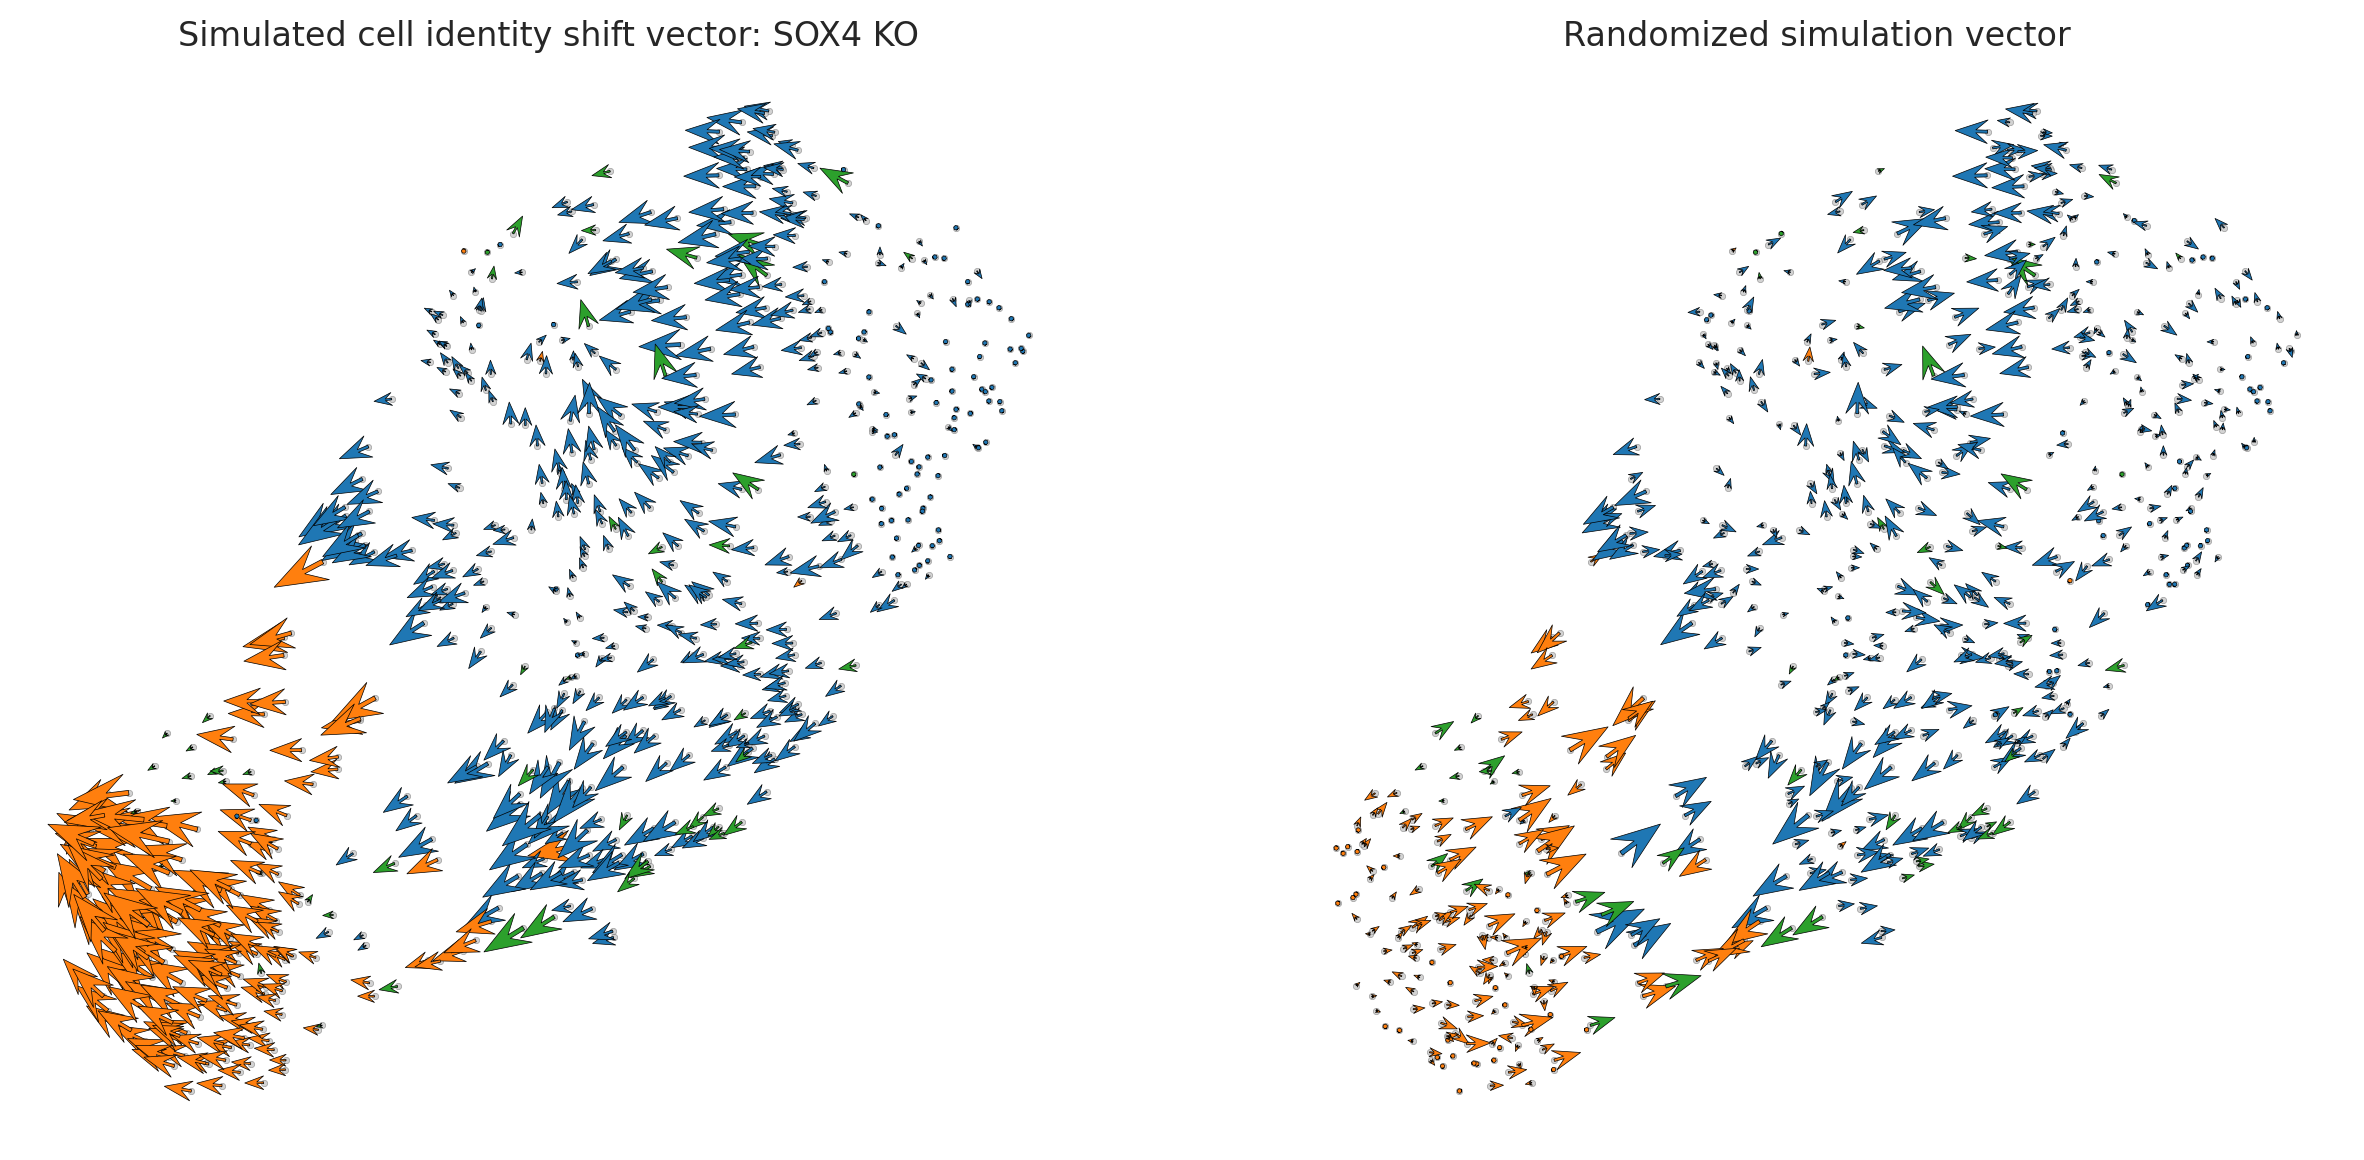

In [14]:
fig, ax = plt.subplots(1, 2,  figsize=[15, 7])

scale = 20
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

## 4.2. Vector field graph

We will visualize the simulation results as a vector field on a digitized grid. Single cell transition vectors are grouped by grid point.

### 4.2.1 Find parameters for n_grid and min_mass

`n_grid`: Number of grid points.

    
`min_mass`: Threshold value for the cell density. The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.

In [15]:
# n_grid = 40 is a good starting value.
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

Please run `oracle.suggest_mass_thresholds()` to display a range of min_mass parameter values and choose a value to fit the data.

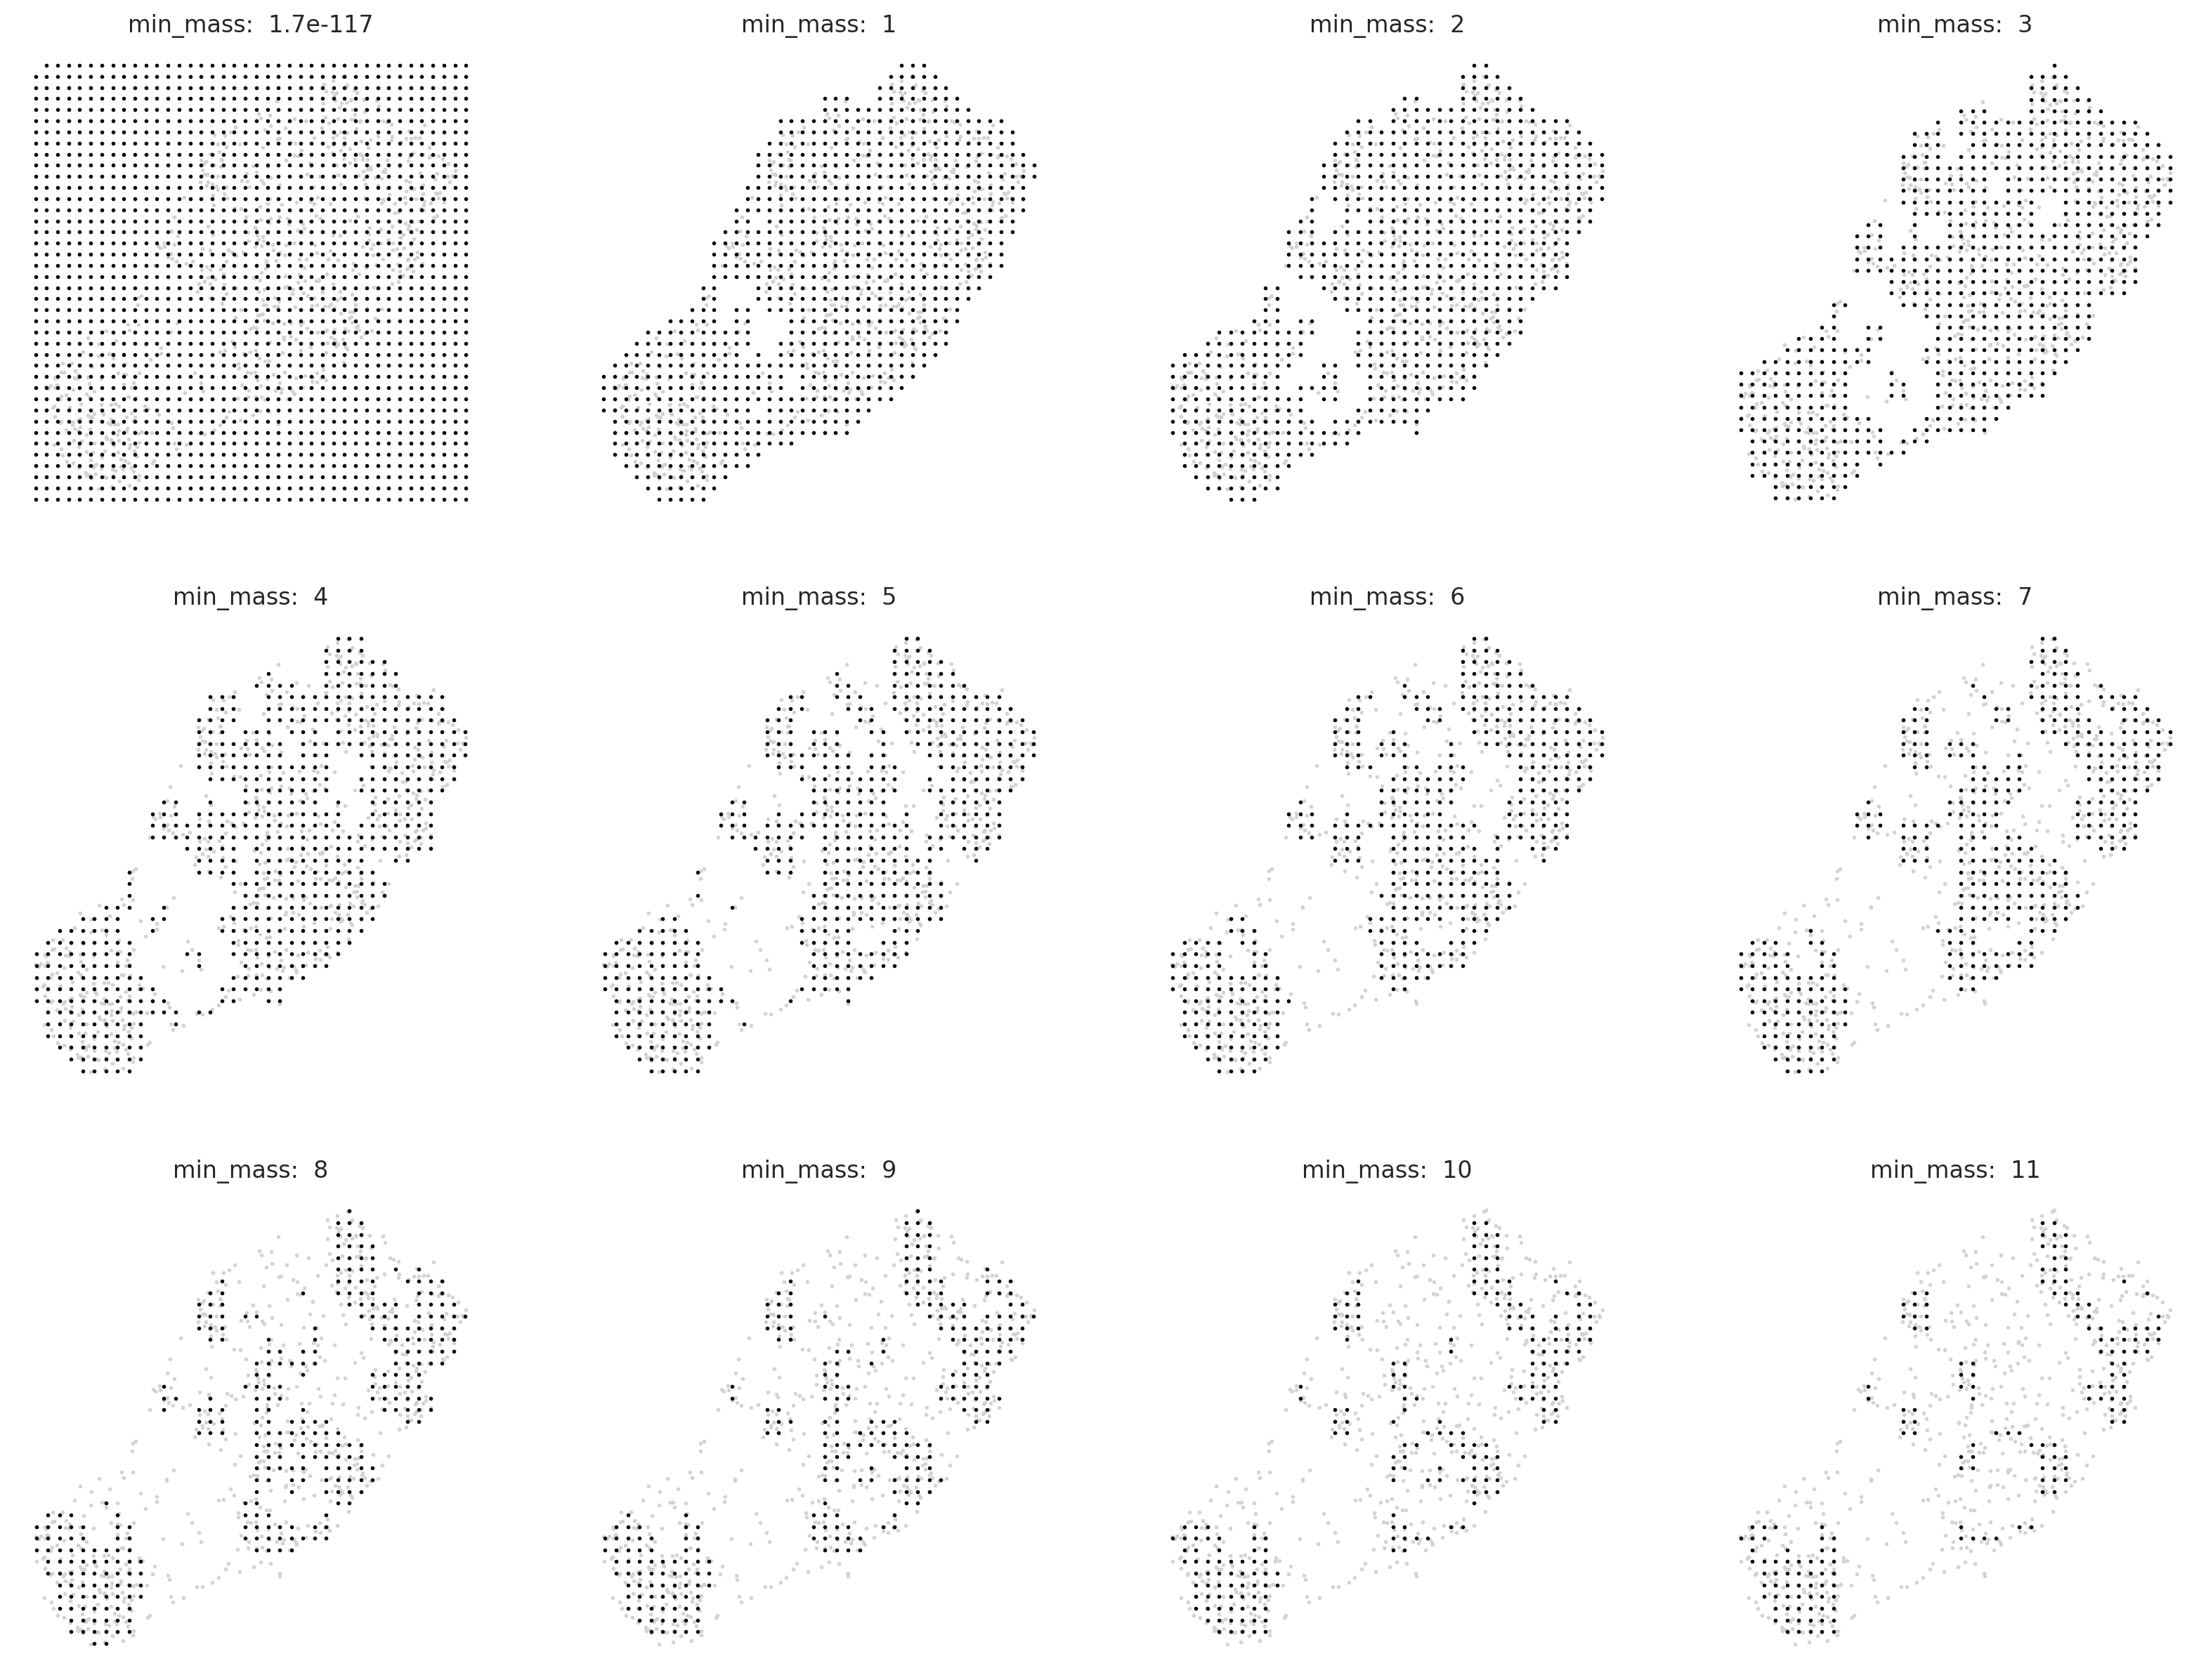

In [16]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

According to the results, the optimal min_mass is around ...

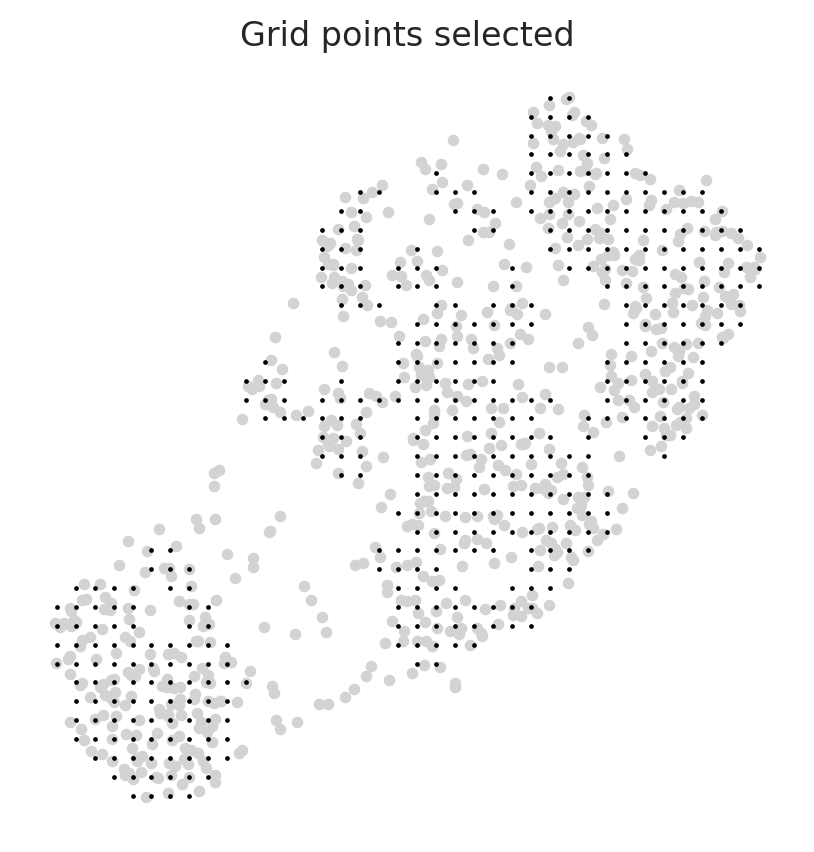

In [17]:
min_mass = 6
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

### 4.2.2 Plot vector fields

- Again, we need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter that provides good visualization.

- If you don’t see any vector, you can try the smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means the scale parameter is too small.

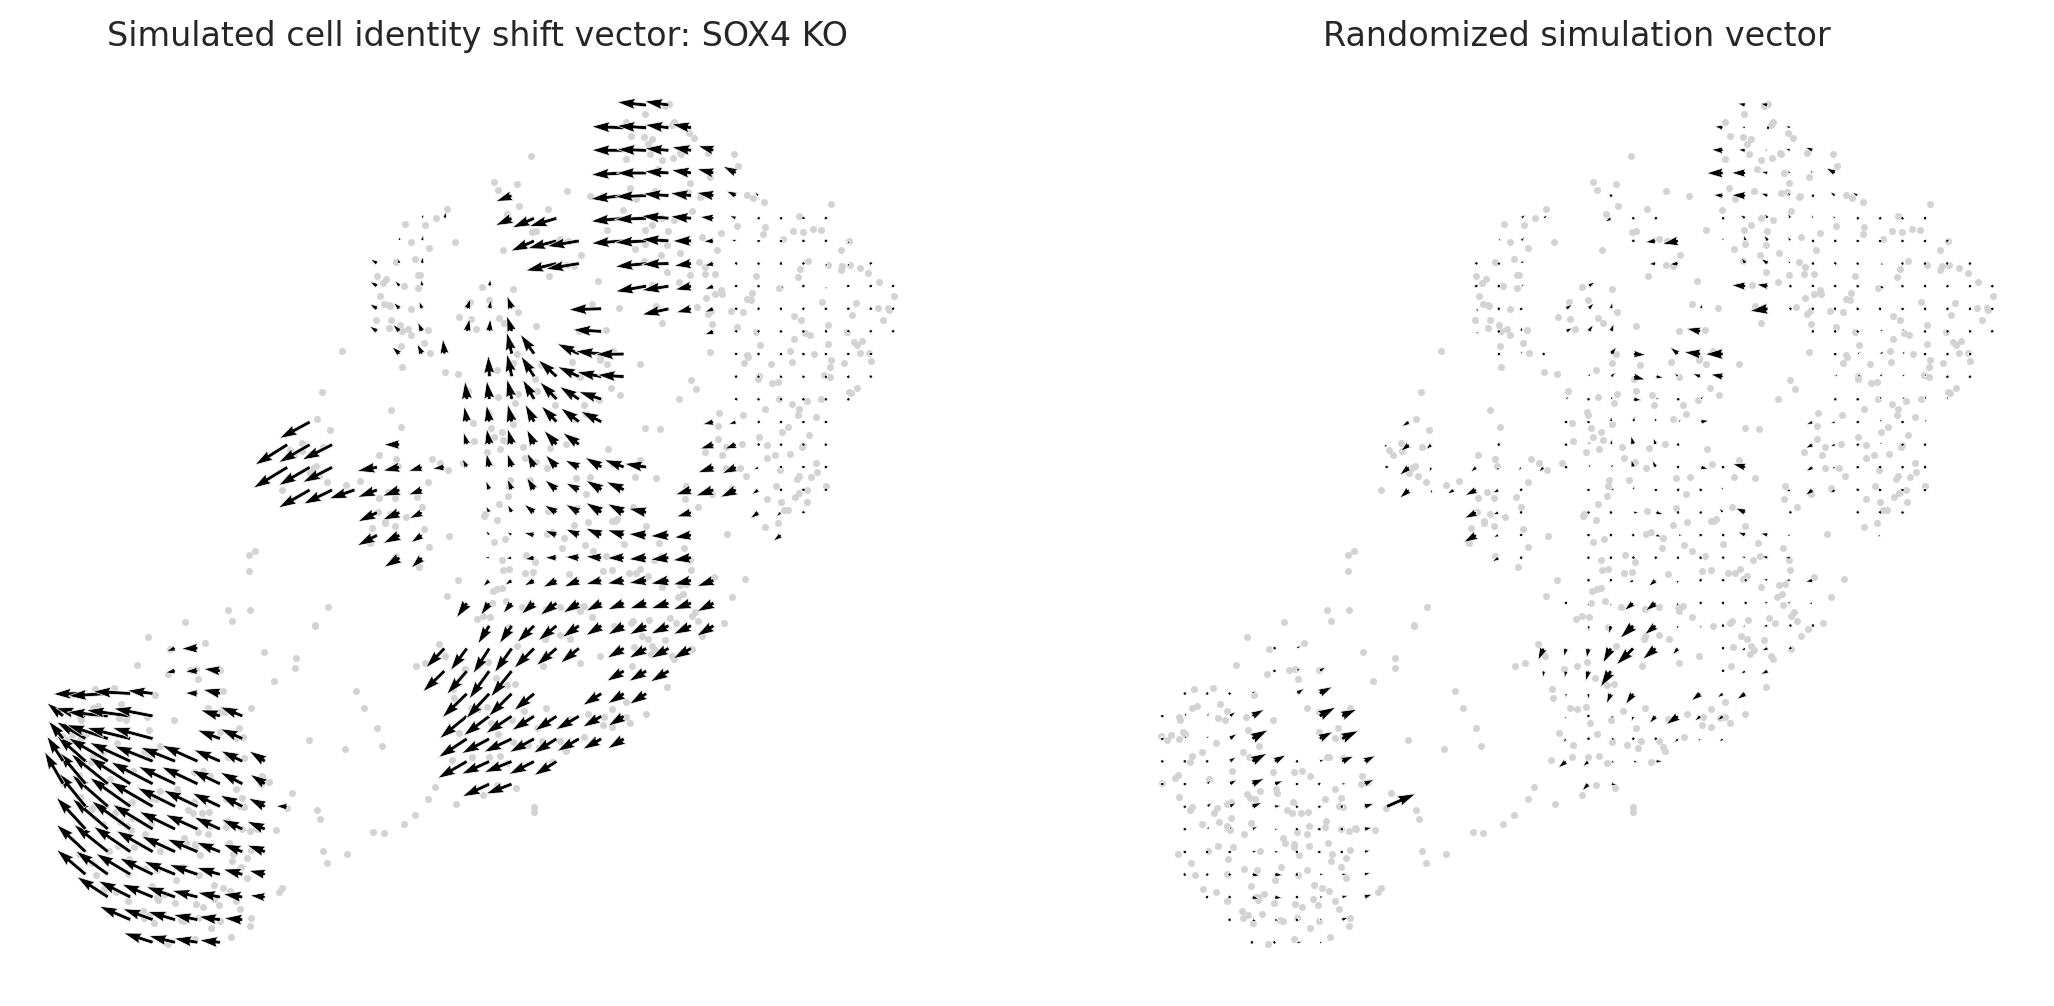

In [18]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 18
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

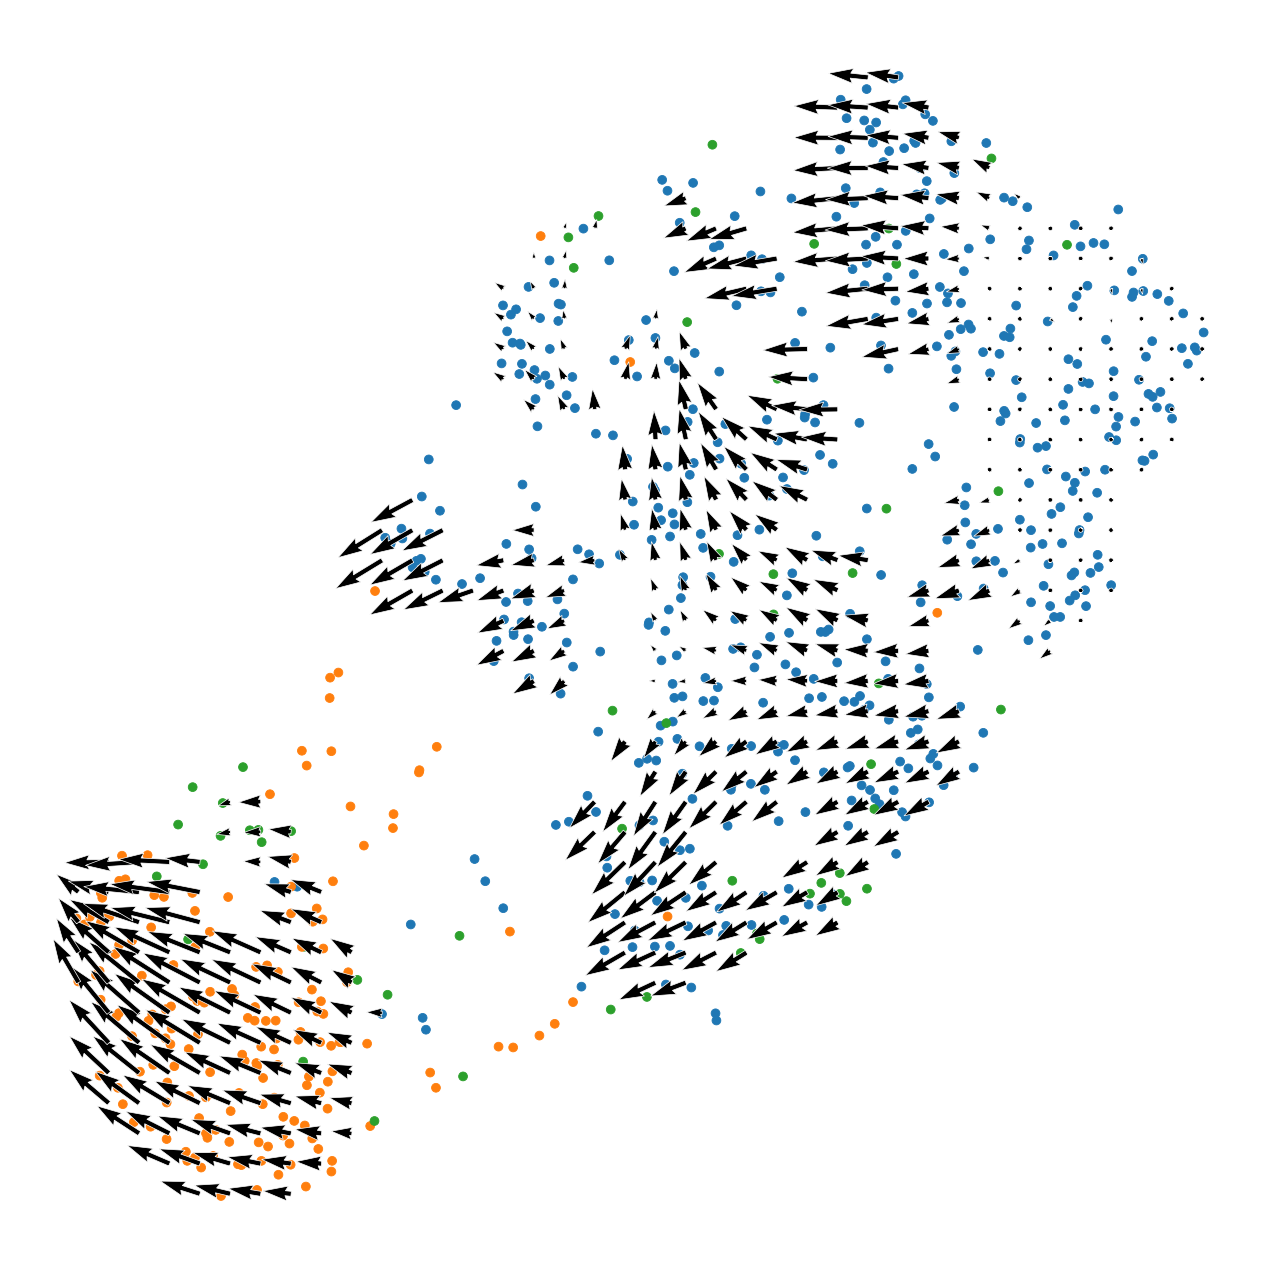

In [19]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

# 5. Compare simulation vector with development vectors

- As shown above, we can simulate how TF perturbations affect cell identity and visualize the results as a vector field map.

- To interpret the results, it is necessary to take into account the direction of natural differentiation. We will compare the simulated perturbation vectors with the developmental gradient vectors. By comparing them, we can intuitively understand how TFs impact cell fate determination during development. This perspective is also important for estimating the experimental perturbation results.

- Here, we will calculate the development vector field using pseudotime gradient as follows.

1. Transfer the **pseudotime** data into an n x n digitized grid.

2. Calculate the 2D gradient of pseudotime to get vector field.

3. Compare the in silico TF perturbation vector field with the development vector field by calculating inner product between these two vectors.

- Note: Other methods may be used to represent a continuous scRNA-seq trajectory flow. For example, RNA velocity analysis is a good way to estimate the direction of cell differentiation. Choose the method that best suits your data.

**If you are analyzing your own scRNA-seq data, please calculate pseudotime before starting this analysis.**

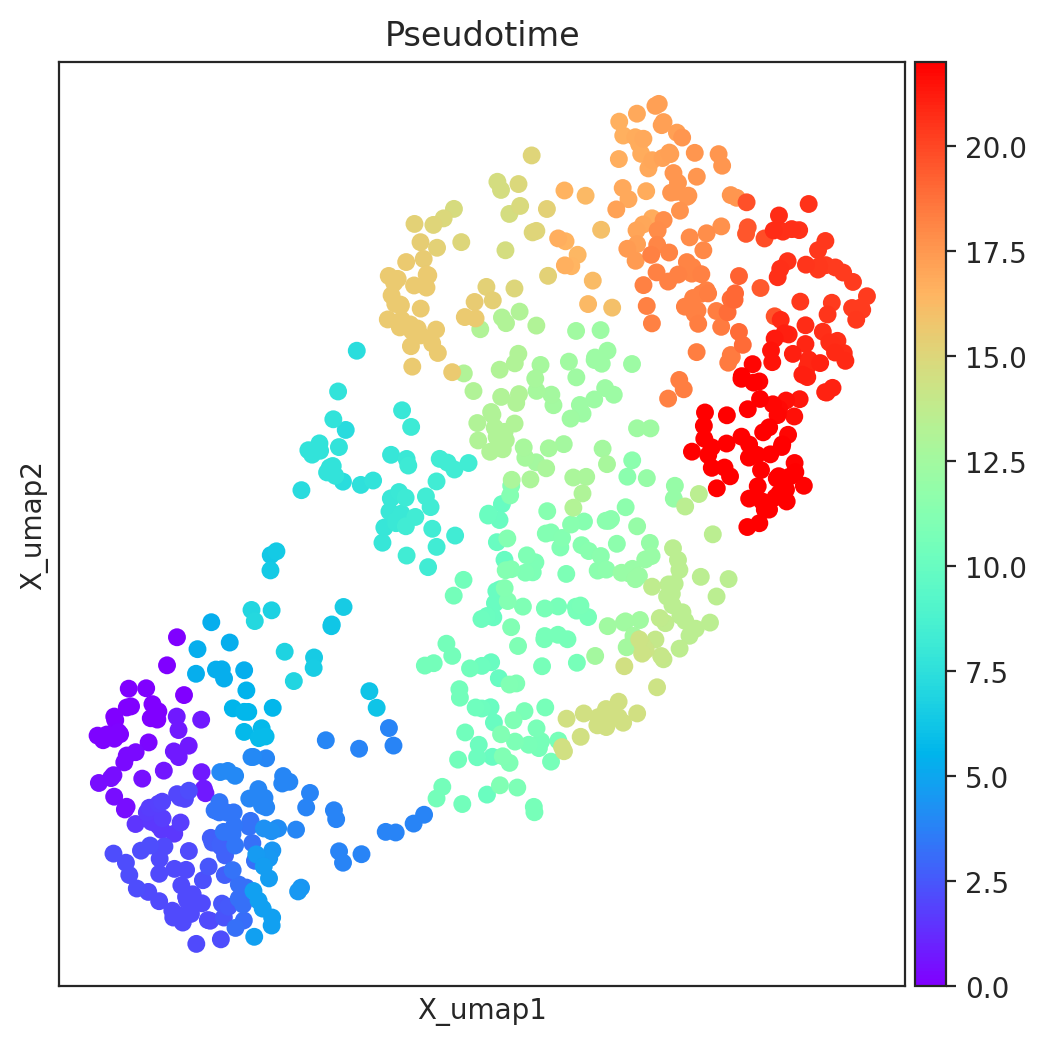

In [20]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

In [21]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

We need to set `n_grid` and `min_mass` for the pseudotime grid point calculation too. n_grid: Number of grid point.

We already know approproate values for them. Please set the same values as step 4.2.1 above.

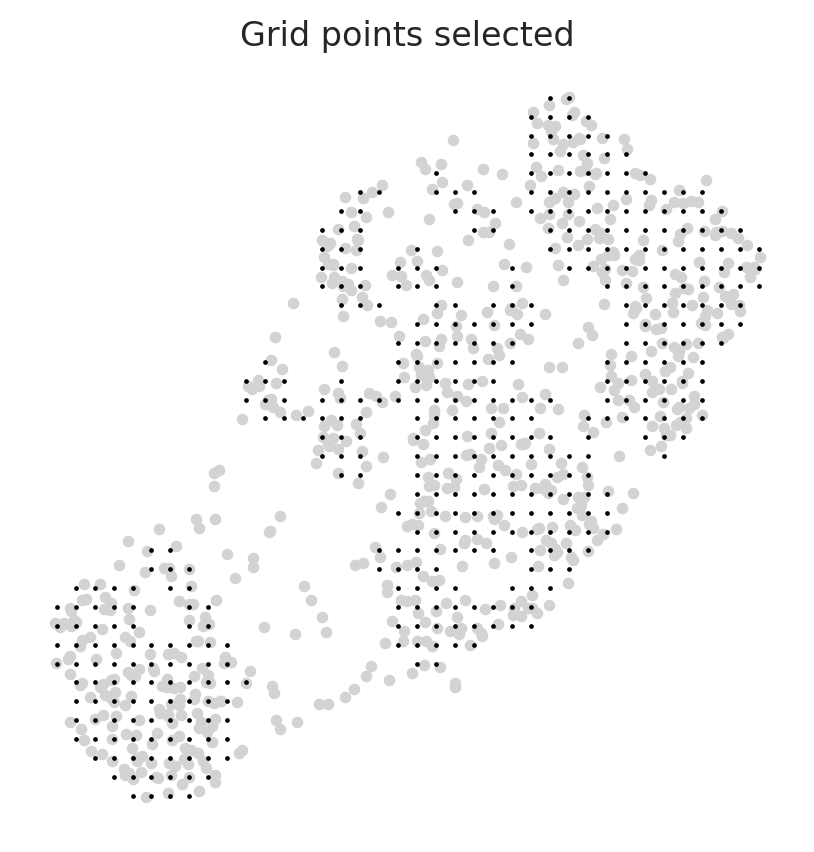

In [22]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

Next, we convert the pseudotime data into grid points. For this calculation we can chose one of two methods.

- `knn`: K-Nearesr Neighbor regression. You will need to set number of neighbors. Please adjust n_knn for best results.This will depend on the population size and density of your scRNA-seq data.

- `polynomial`: Polynomial regression using x-axis and y-axis of dimensional reduction space.

In general, this method will be more robust. Please use this method if knn method does not work. `n_poly` is the number of degrees for the polynomial regression model. Please try to find appropriate `n_poly` searching for best results.

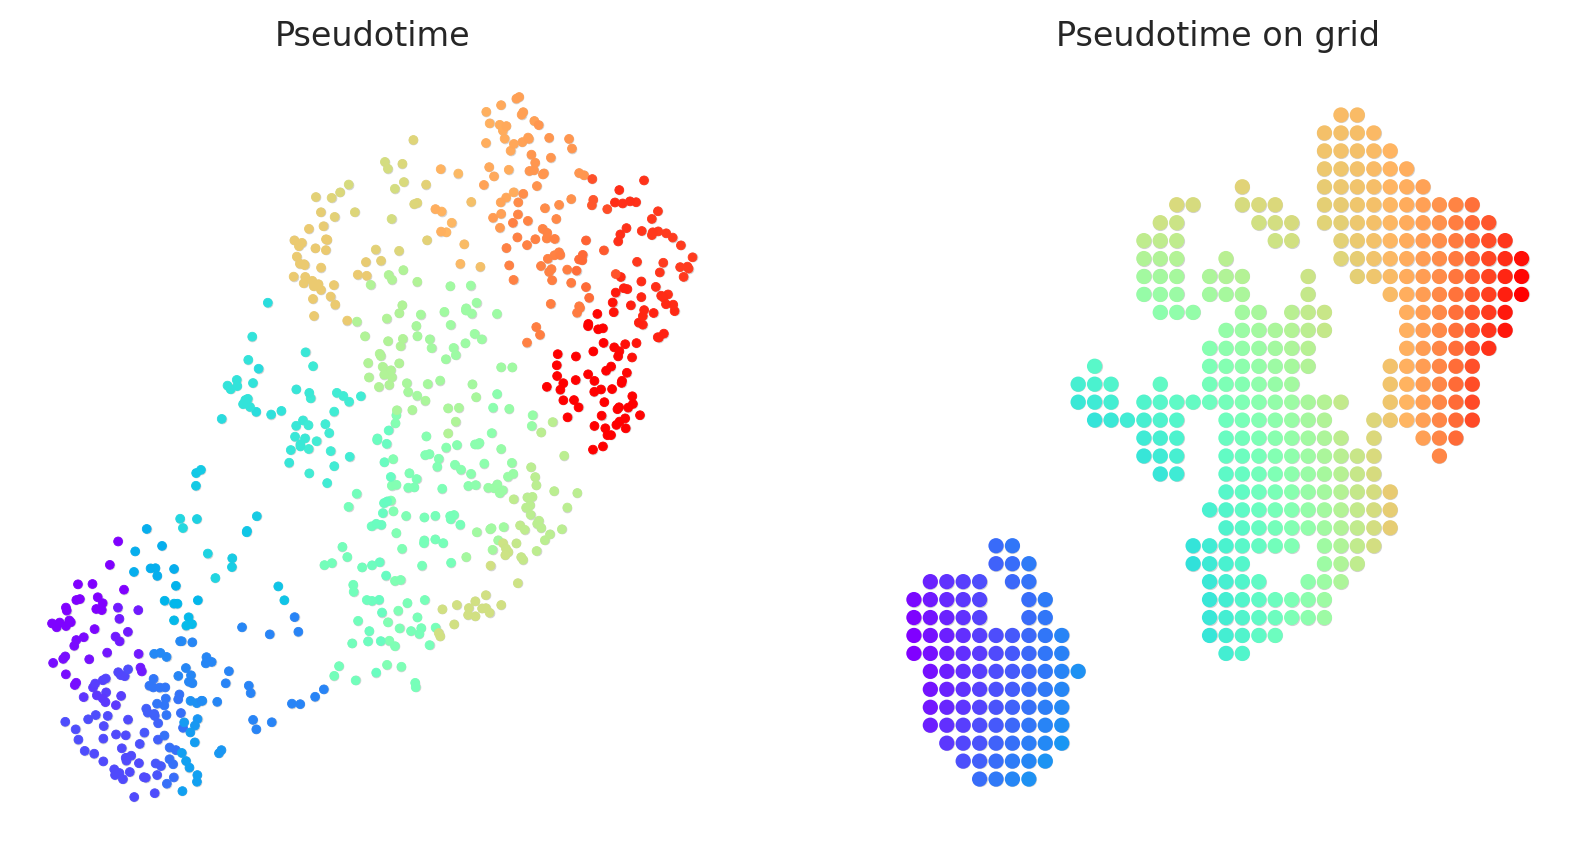

In [23]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

Calculate the 2D vector map to represents the pseudotime gradient. After the gradient calculation, the length of the vector will be normalized automatically.

Please adjust the `scale` parameter to adjust vector length visualization.

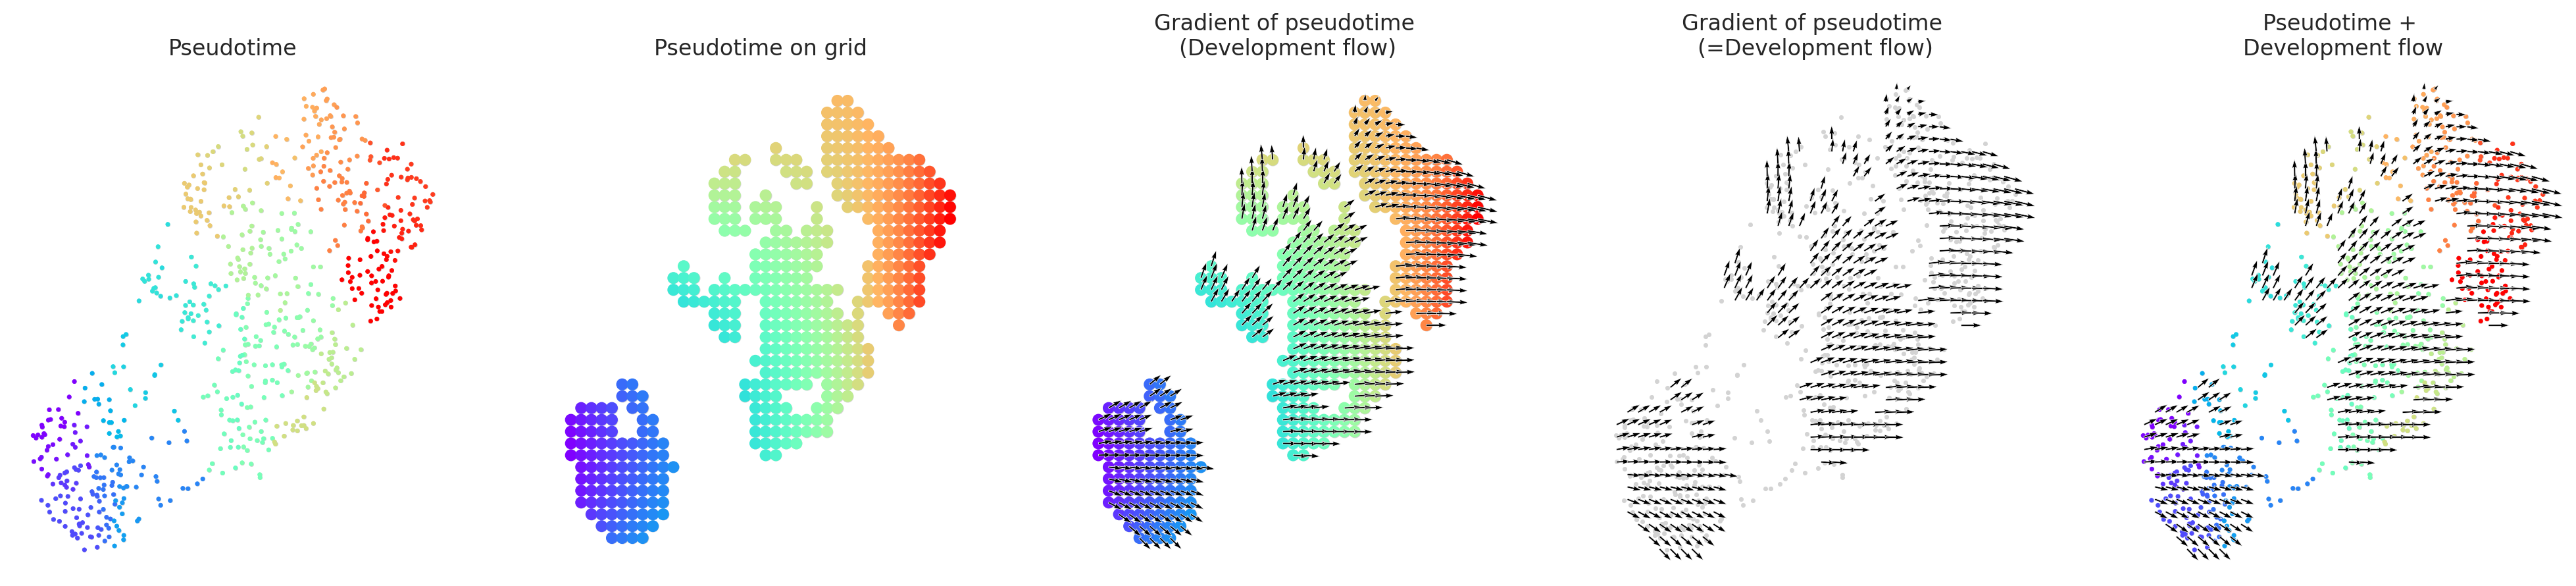

In [24]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 25
gradient.visualize_results(scale=scale_dev, s=5)

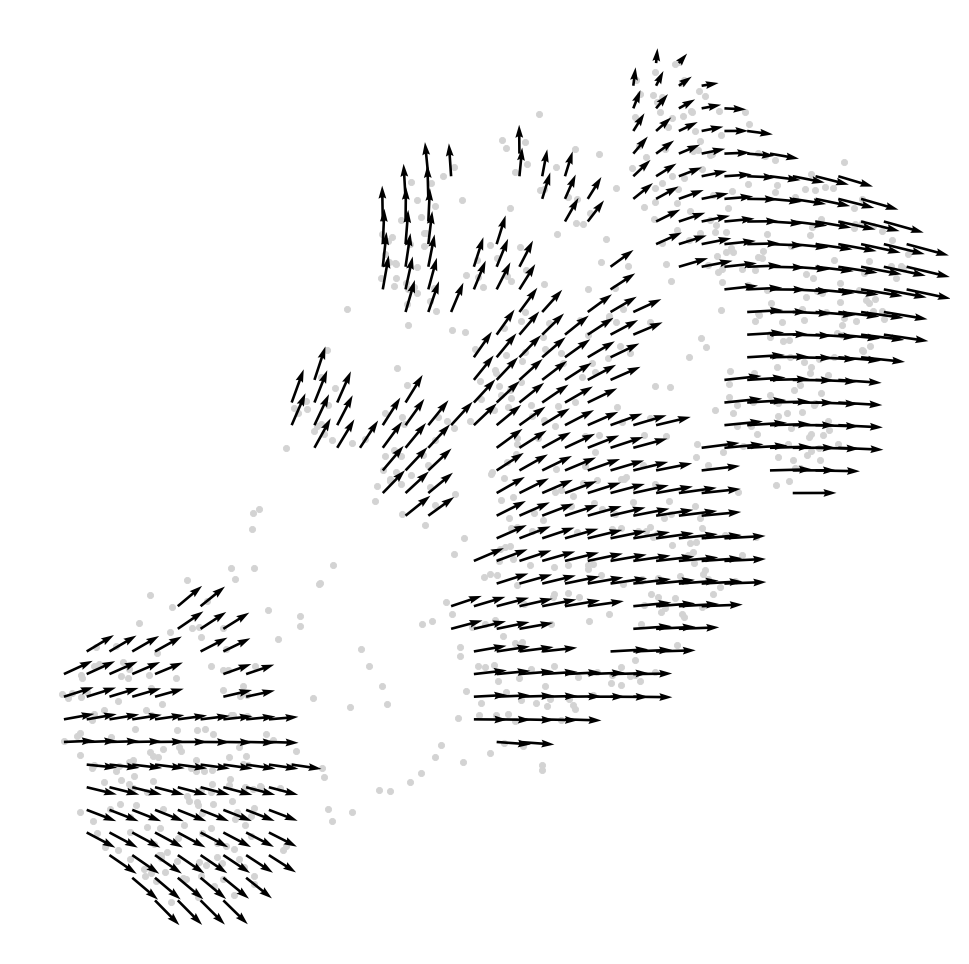

In [25]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [26]:
gradient.to_hdf5(f"data/{cell_name}.celloracle.gradient")

We will use the inner product calculations to quantitatively compare the 2D developmental flow and perturbation simulation vectors. > If you are not familiar with Inner product / Dot product, please see https://en.wikipedia.org/wiki/Dot_product

- **The inner product represents the similarity between two vectors.**

- Using the inner product, we compare the 2D vector field of perturbation simulation and development flow.

- The inner product will be a positive value when two vectors are pointing in the same direction.

- Conversely, the inner product will be a negative value when two vectors are pointing in the opposing directions.

- The length of the vectors also affects the magnitude of inner product value.


In summary, we quantitatively compare the directionality and size of vectors between perturbation simulation and natural differentiation using inner product, and we define the score as **perturbation score (PS)**.

- **A negative PS** means that the TF perturbation would **block differentiation**.

- **A positive PS** means that the TF perturbation would **promote differentiation**.

In [27]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

- Here, need to adjust the `vm` parameter for the PS score color visualization. Please seek to find the optimal `vm` parameter that provides good visualization.

- If you don’t see any color in the left panel below, you can try the smaller `vm` parameter to magnify the scale of vm visualization. However, if you see colors in the randomized results (right panel), it means the `vm` parameter is too small.

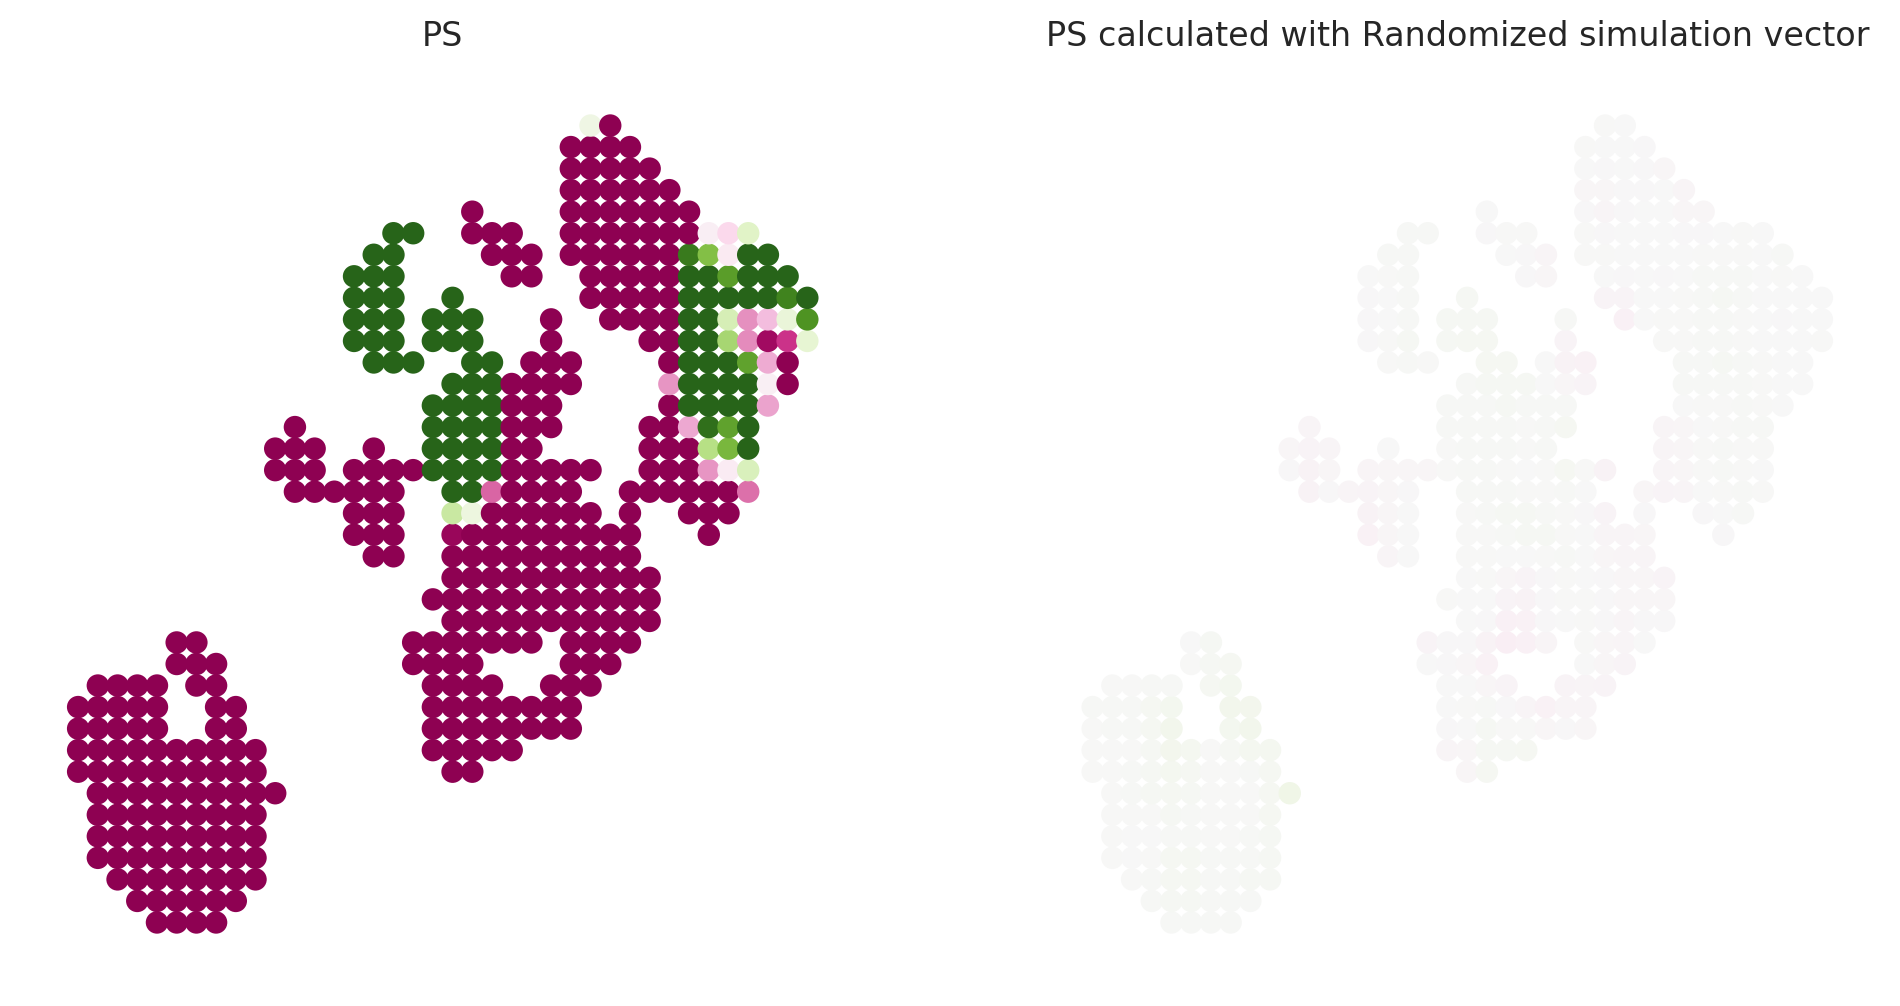

In [28]:
# Show perturbation scores
vm = 5

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax[0])
ax[0].set_title(f"PS")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS calculated with Randomized simulation vector")
plt.show()

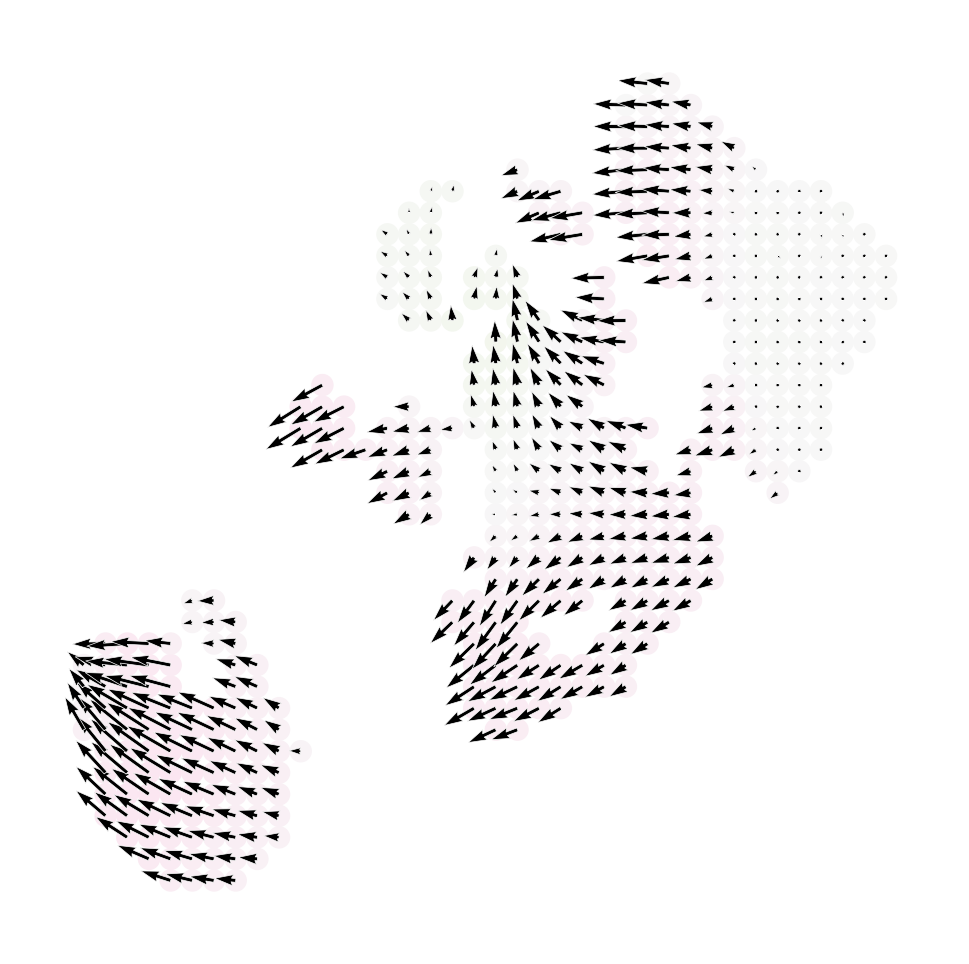

In [29]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

2025-01-13 22:38:33,119 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-13 22:38:33,124 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


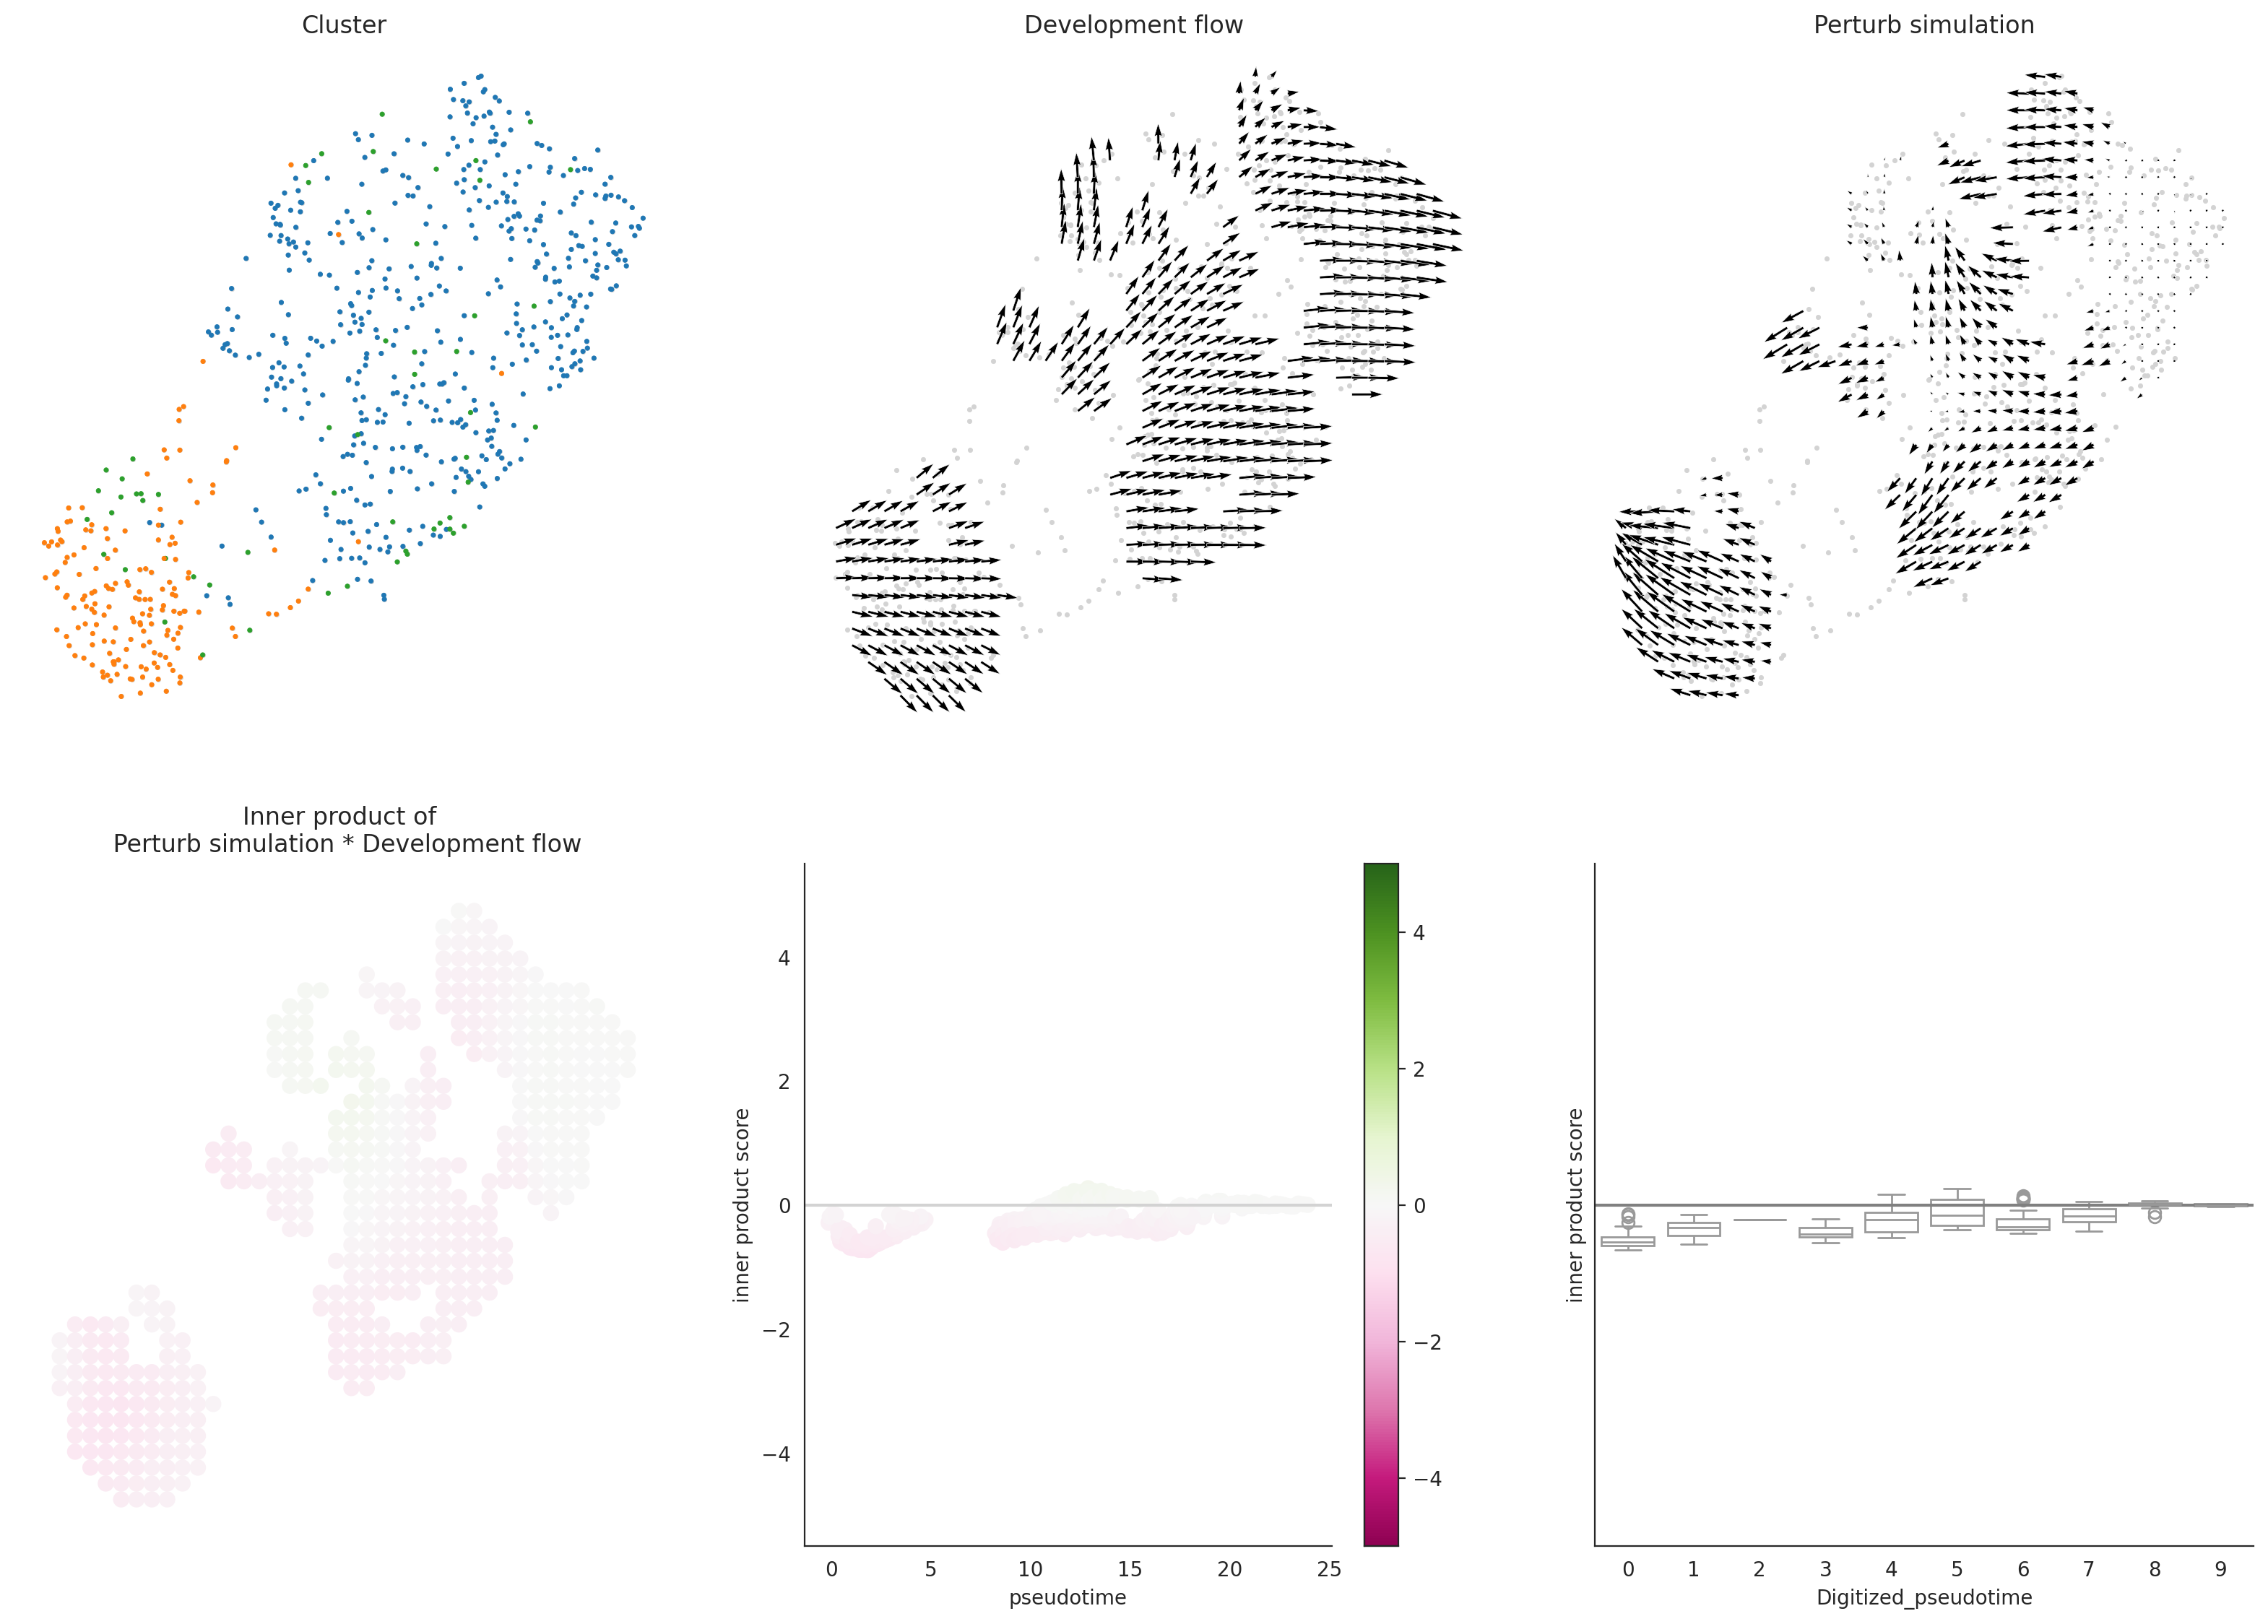

In [30]:
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=vm)
plt.savefig(f"figures/Fig.CellOracle.{cell_name}_SOX4.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 6. Plot

Sim

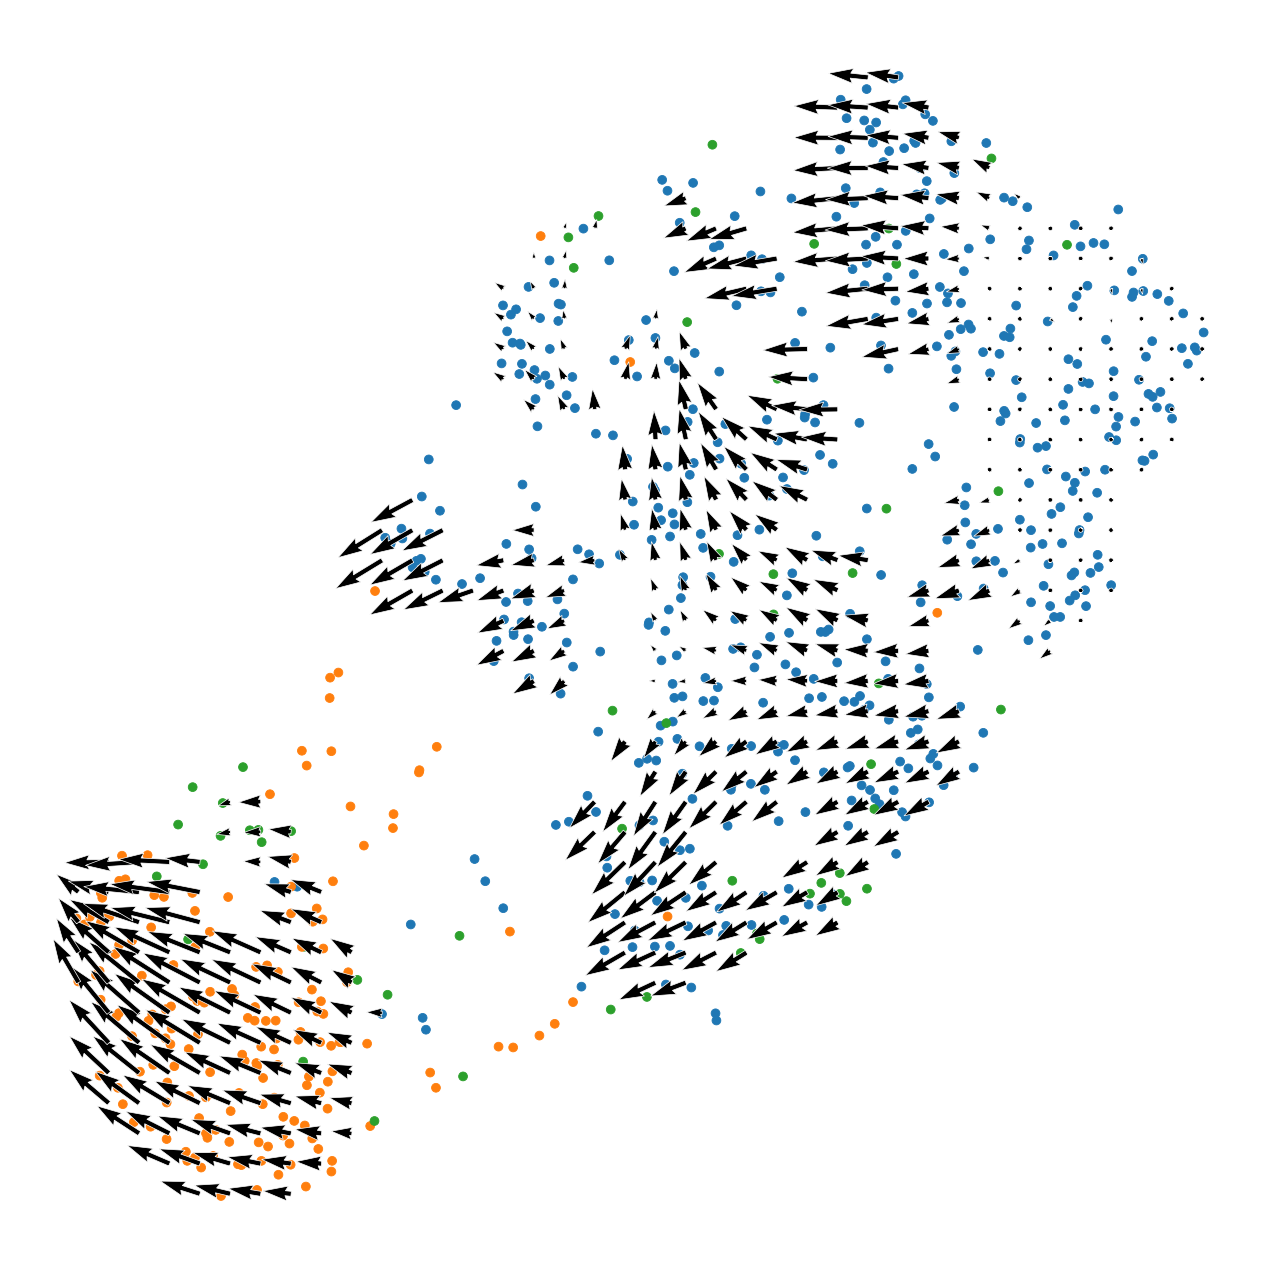

In [31]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

plt.savefig(f"figures/Fig.CellOracle.{cell_name}_PerturbSimulation.pdf", format="pdf", bbox_inches="tight")
plt.show()

Dev

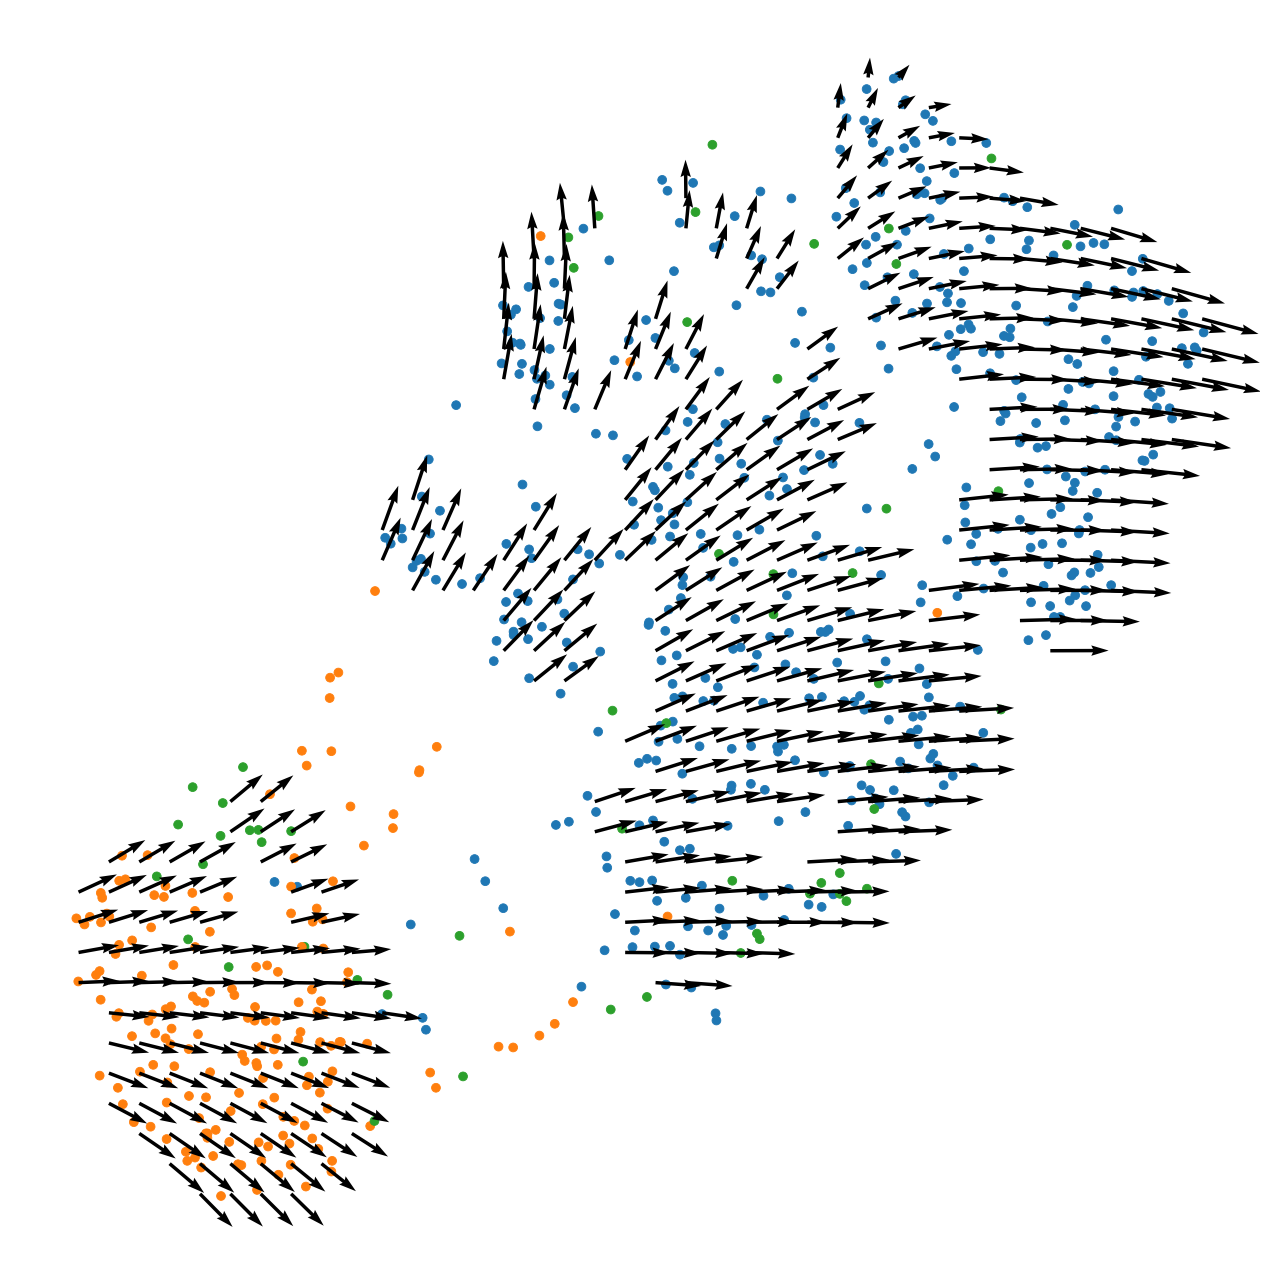

In [32]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax, show_background=False)

plt.savefig(f"figures/Fig.CellOracle.{cell_name}_DevelopmentFlow.pdf", format="pdf", bbox_inches="tight")
plt.show()